In [3]:
import pandas as pd
import numpy as np
from datetime import datetime

import matplotlib
matplotlib.use('Agg')
%matplotlib inline

import matplotlib.pyplot as plt

import torch
import torch.nn as nn 
from torch.autograd import Variable
import torch.optim as optim

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

In [5]:
## import data
df = pd.read_excel("附件1：物流网络历史货量数据.xlsx")
df

,场地1,场地2,日期,货量
0,DC3,DC5,2021-01-01,3
1,DC3,DC10,2021-01-01,4
2,DC3,DC14,2021-01-01,4
3,DC5,DC3,2021-01-01,41
4,DC5,DC9,2021-01-01,3
...,...,...,...,...
177842,DC73,DC5,2022-12-31,2479
177843,DC73,DC8,2022-12-31,150
177844,DC73,DC10,2022-12-31,8116
177845,DC73,DC14,2022-12-31,6139


In [6]:
# Rename column names
df.rename(columns={"场地1":"one", "场地2":"two", "日期":"date", "货量":"value"}, inplace=True)
print(df.columns)

Index(['one', 'two', 'date', 'value'], dtype='object')


In [7]:
from numpy.ma.extras import unique
#to required origin
DC14 = df[df['two'] == "DC14"]
dic_14 = {}
for i in unique(DC14['one']):
  dic_14[i] = len(DC14[DC14['one'] == i])

DC20 = df[df['two'] == "DC20"]
dic_20 = {}
for i in unique(DC20['one']):
  dic_20[i] = len(DC20[DC20['one'] == i])

DC25 = df[df['two'] == "DC25"]
dic_25 = {}
for i in unique(DC25['one']):
  dic_25[i] = len(DC25[DC25['one'] == i])

In [8]:
sorted14 = sorted(dic_14.items(), key=lambda item: item[1], reverse=True)
sorted20 = sorted(dic_20.items(), key=lambda item: item[1], reverse=True)
sorted25 = sorted(dic_25.items(), key=lambda item: item[1], reverse=True)
print(sorted14[:10])
print(sorted20[:10])
print(sorted25[:10])

[('DC10', 730), ('DC15', 730), ('DC19', 730), ('DC20', 730), ('DC22', 730), ('DC25', 730), ('DC28', 730), ('DC30', 730), ('DC36', 730), ('DC42', 730)]
[('DC4', 9), ('DC10', 8), ('DC62', 8), ('DC55', 6), ('DC14', 5), ('DC19', 2), ('DC21', 2), ('DC17', 1), ('DC22', 1), ('DC23', 1)]
[('DC53', 39), ('DC9', 4), ('DC10', 3), ('DC14', 3), ('DC8', 1)]


In [9]:
#to required destination (required destination需求量)
to10 = df[df['two'] == "DC10"]
dic_to_10 = {i : len(to10[to10['one'] == i]) for i in unique(to10['one'])}

to35 = df[df['two'] == "DC35"]
dic_to_35 = {i : len(to35[to35['one'] == i]) for i in unique(to35['one'])}

to62 = df[df['two'] == "DC62"]
dic_to_62 = {i : len(to62[to62['one'] == i]) for i in unique(to62['one'])}

sorted_to_10 = sorted(dic_to_10.items(), key=lambda item: item[1], reverse=True)
sorted_to_35 = sorted(dic_to_35.items(), key=lambda item: item[1], reverse=True)
sorted_to_62 = sorted(dic_to_62.items(), key=lambda item: item[1], reverse=True)

print(sorted_to_10)
print(sorted_to_35)
print(sorted_to_62)

[('DC14', 726), ('DC20', 724), ('DC23', 724), ('DC36', 724), ('DC19', 722), ('DC17', 721), ('DC25', 721), ('DC22', 720), ('DC30', 720), ('DC28', 718), ('DC15', 717), ('DC44', 717), ('DC51', 716), ('DC55', 716), ('DC38', 715), ('DC31', 713), ('DC73', 711), ('DC47', 710), ('DC26', 706), ('DC46', 705), ('DC48', 688), ('DC7', 684), ('DC71', 679), ('DC43', 660), ('DC42', 659), ('DC50', 658), ('DC21', 573), ('DC8', 520), ('DC52', 499), ('DC4', 497), ('DC34', 478), ('DC40', 440), ('DC62', 319), ('DC5', 315), ('DC37', 303), ('DC58', 239), ('DC68', 212), ('DC9', 209), ('DC57', 208), ('DC3', 205), ('DC66', 200), ('DC27', 190), ('DC45', 183), ('DC72', 148), ('DC56', 139), ('DC70', 125), ('DC41', 91), ('DC59', 76), ('DC35', 74), ('DC53', 72), ('DC60', 72), ('DC13', 55), ('DC49', 48), ('DC74', 43), ('DC33', 28), ('DC11', 26), ('DC39', 19), ('DC16', 16), ('DC12', 11), ('DC24', 11), ('DC64', 10), ('DC65', 9), ('DC2', 7), ('DC67', 7), ('DC18', 6), ('DC61', 5), ('DC76', 5), ('DC63', 4), ('DC69', 4), ('

In [10]:
#Required route
DC14_DC10 = df[(df["one"] == "DC14") & (df["two"] == "DC10")]
DC20_DC35 = df[(df["one"] == "DC20") & (df["two"] == "DC35")]
DC25_DC62 = df[(df["one"] == "DC25") & (df["two"] == "DC62")]
DC14_DC10 = DC14_DC10[["date", "value"]]
DC20_DC35 = DC20_DC35[["date", "value"]]
DC25_DC62 = DC25_DC62[["date", "value"]]

In [11]:
#Dependent route
#to required origin
#DC14->DC10
DC15_DC14 = df[(df["one"] == "DC15") & (df["two"] == "DC14")]
#DC20->DC35
DC4_DC20 = df[(df["one"] == "DC4") & (df["two"] == "DC20")]
#DC25->DC62
DC53_DC25 = df[(df["one"] == "DC53") & (df["two"] == "DC25")]

#to required destination (required destination需求量)
#DC14->DC10
DC20_DC10 = df[(df["one"] == "DC20") & (df["two"] == "DC10")]
#DC20->DC35
DC10_DC35 = df[(df["one"] == "DC10") & (df["two"] == "DC35")]
#DC25->DC62
DC8_DC62 = df[(df["one"] == "DC8") & (df["two"] == "DC62")]

In [12]:
date_range = pd.date_range("2021-1-1", "2022-12-31")
all_dates_df = pd.DataFrame({'date': date_range})
DC14_DC10 = pd.merge(all_dates_df, DC14_DC10, on='date', how='left')
DC14_DC10['value'].fillna(0, inplace=True)
DC20_DC35 = pd.merge(all_dates_df, DC20_DC35, on='date', how='left')
DC20_DC35['value'].fillna(0, inplace=True)
DC25_DC62 = pd.merge(all_dates_df, DC25_DC62, on='date', how='left')
DC25_DC62['value'].fillna(0, inplace=True)
print(len(DC14_DC10))
print(len(DC20_DC35))
print(len(DC25_DC62))

730
730
730


In [79]:
#route1: DC14->DC10
route1 = pd.merge(DC14_DC10, DC15_DC14, on='date', how='left')
route1 = pd.merge(route1, DC20_DC10, on='date', how='left')
route1 = route1[['date', 'value_x', 'value_y', 'value']]
route1.rename(columns={"date":"date", "value_x":"value", "value_y":"toDC14", "value":"toDC10"}, inplace=True)
route1['toDC14'].fillna(0, inplace = True)
route1['toDC10'].fillna(0, inplace = True)
route1.set_index('date', inplace=True)
route1
# new route1
data = {
    'date': pd.date_range('2023-01-01', '2023-01-31'),
    'value': range(1, 32),
    'toDC14': range(1001, 1032),
    'toDC10': range(2001, 2032)
}
x = np.arange(669,730)
nvalue = np.polyfit(x,route1['value'][669:],1)
n14 = np.polyfit(x,route1['toDC14'][669:],1)
n10 = np.polyfit(x,route1['toDC10'][669:],1)

In [82]:
n14n,n10n,nv= [],[],[]
for i in range(730,761):
    n14n.append(n14[0]*i+n14[1])
    n10n.append(n10[0]*i+n10[1])
    nv.append(nvalue[0]*i+nvalue[1])

In [83]:
df_future = pd.DataFrame(data)
df_future.set_index('date', inplace=True)
df_future['value'] = nv
df_future['toDC14'] = n14n
df_future['toDC10'] = n10n
merged_df = pd.concat([route1, df_future], ignore_index=False)
merged_df

,value,toDC14,toDC10
date,,,
2021-01-01,273.000000,7226.000000,27539.000000
2021-01-02,247.000000,6456.000000,25891.000000
2021-01-03,160.000000,3206.000000,19351.000000
2021-01-04,288.000000,2149.000000,24933.000000
2021-01-05,188.000000,6005.000000,27643.000000
...,...,...,...
2023-01-27,11749.675992,6387.519989,5295.386621
2023-01-28,11473.307351,6391.625172,5218.111264
2023-01-29,11196.938710,6395.730354,5140.835907


In [84]:
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio

In [85]:
df = merged_df
target_sensor = "value"
features = list(df.columns.difference([target_sensor]))

forecast_lead = 1
target = f"{target_sensor}_lead{forecast_lead}"

df[target] = df[target_sensor].shift(-forecast_lead)
df = df.iloc[:-forecast_lead]

In [87]:
test_start = "2022-9-01"

df_train = df.loc[:test_start].copy()
df_test = df.loc[test_start:].copy()

df_train

,value,toDC14,toDC10,value_lead1
date,,,,
2021-01-01,273.0,7226.0,27539.0,247.0
2021-01-02,247.0,6456.0,25891.0,160.0
2021-01-03,160.0,3206.0,19351.0,288.0
2021-01-04,288.0,2149.0,24933.0,188.0
2021-01-05,188.0,6005.0,27643.0,159.0
...,...,...,...,...
2022-08-28,57603.0,5686.0,26886.0,56810.0
2022-08-29,56810.0,5007.0,13488.0,59169.0
2022-08-30,59169.0,2322.0,9263.0,62885.0


In [88]:
target_mean = df_train[target].mean()
target_stdev = df_train[target].std()

for c in df_train.columns:
    mean = df_train[c].mean()
    stdev = df_train[c].std()

    df_train[c] = (df_train[c] - mean) / stdev
    df_test[c] = (df_test[c] - mean) / stdev

In [89]:
import torch
from torch.utils.data import Dataset

class SequenceDataset(Dataset):
    def __init__(self, dataframe, target, features, sequence_length=5):
        self.features = features
        self.target = target
        self.sequence_length = sequence_length
        self.y = torch.tensor(dataframe[target].values).float()
        self.X = torch.tensor(dataframe[features].values).float()

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, i): 
        if i >= self.sequence_length - 1:
            i_start = i - self.sequence_length + 1
            x = self.X[i_start:(i + 1), :]
        else:
            padding = self.X[0].repeat(self.sequence_length - i - 1, 1)
            x = self.X[0:(i + 1), :]
            x = torch.cat((padding, x), 0)

        return x, self.y[i]

In [90]:
from torch.utils.data import DataLoader
torch.manual_seed(101)
temp = ["value",	"toDC14",	"toDC10"	]
batch_size = 16
sequence_length = 2

train_dataset = SequenceDataset(
    df_train,
    target=target,
    features=temp,
    sequence_length=sequence_length
)
test_dataset = SequenceDataset(
    df_test,
    target=target,
    features=temp,
    sequence_length=sequence_length
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

X, y = next(iter(train_loader))

print("Features shape:", X.shape)
print("Target shape:", y.shape)

Features shape: torch.Size([16, 2, 3])
Target shape: torch.Size([16])


In [91]:
from torch import nn

class ShallowRegressionLSTM(nn.Module):
    def __init__(self, num_sensors, hidden_units):
        super().__init__()
        self.num_sensors = num_sensors  # this is the number of features
        self.hidden_units = hidden_units
        self.num_layers = 1

        self.lstm = nn.LSTM(
            input_size=num_sensors,
            hidden_size=hidden_units,
            batch_first=True,
            num_layers=self.num_layers
        )

        self.linear = nn.Linear(in_features=self.hidden_units, out_features=1)

    def forward(self, x):
        batch_size = x.shape[0]
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()
        
        _, (hn, _) = self.lstm(x, (h0, c0))
        out = self.linear(hn[0]).flatten()  # First dim of Hn is num_layers, which is set to 1 above.

        return out

In [92]:
learning_rate = 0.0001
num_hidden_units = 64

model = ShallowRegressionLSTM(num_sensors=len(temp), hidden_units=num_hidden_units)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [93]:
train_loss = []
test_loss =[]

def train_model(data_loader, model, loss_function, optimizer):
    num_batches = len(data_loader)
    total_loss = 0
    model.train()
    
    for X, y in data_loader:
        output = model(X)
        loss = loss_function(output, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / num_batches
    train_loss.append(avg_loss)
    print(f"Train loss: {avg_loss}")

def test_model(data_loader, model, loss_function):
    
    num_batches = len(data_loader)
    total_loss = 0

    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            output = model(X)
            total_loss += loss_function(output, y).item()

    avg_loss = total_loss / num_batches
    test_loss.append(avg_loss)
    print(f"Test loss: {avg_loss}")


print("Untrained test\n--------")
test_model(test_loader, model, loss_function)
print()

for ix_epoch in range(100):
    print(f"Epoch {ix_epoch}\n---------")
    train_model(train_loader, model, loss_function, optimizer=optimizer)
    test_model(test_loader, model, loss_function)
    print()

Untrained test
--------
Test loss: 0.3372368022799492

Epoch 0
---------
Train loss: 1.0577272788072243
Test loss: 0.3321585163474083

Epoch 1
---------
Train loss: 0.9463384059162285
Test loss: 0.3289996638894081

Epoch 2
---------
Train loss: 0.9385458788810632
Test loss: 0.33009462654590604

Epoch 3
---------
Train loss: 0.8994026829799017
Test loss: 0.32285417467355726

Epoch 4
---------
Train loss: 0.8891003880745325
Test loss: 0.3177338421344757

Epoch 5
---------
Train loss: 0.9097038568594517
Test loss: 0.3130634769797325

Epoch 6
---------
Train loss: 0.8241730569264828
Test loss: 0.3069289788603783

Epoch 7
---------
Train loss: 0.7736426987196469
Test loss: 0.30069061666727065

Epoch 8
---------
Train loss: 0.7553675510944464
Test loss: 0.2997142881155014

Epoch 9
---------
Train loss: 0.714462249706953
Test loss: 0.3046055242419243

Epoch 10
---------
Train loss: 0.6771462223468683
Test loss: 0.3013463824987411

Epoch 11
---------
Train loss: 0.6261780227606113
Test loss: 0

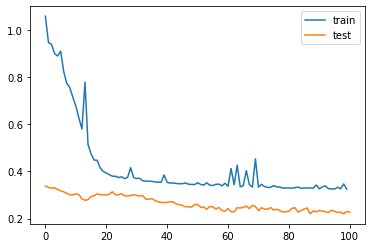

In [94]:
plt.plot(train_loss, label = "train")
plt.plot(test_loss, label = "test")
plt.legend()
plt.show()

In [95]:
def predict(data_loader, model):

    output = torch.tensor([])
    model.eval()
    with torch.no_grad():
        for X, _ in data_loader:
            y_star = model(X)
            output = torch.cat((output, y_star), 0)
    
    return output


train_eval_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

ystar_col = "Model forecast"
df_train[ystar_col] = predict(train_eval_loader, model).numpy()
df_test[ystar_col] = predict(test_loader, model).numpy()

df_out = pd.concat((df_train, df_test))[[target, ystar_col]]

for c in df_out.columns:
    df_out[c] = df_out[c] * target_stdev + target_mean

print(df_out)

             value_lead1  Model forecast
date                                    
2021-01-01    247.000000     2787.134766
2021-01-02    160.000000     2759.253906
2021-01-03    288.000000     2729.472656
2021-01-04    188.000000     1846.554688
2021-01-05    159.000000     1308.732422
...                  ...             ...
2023-01-26  11749.675992     3616.525391
2023-01-27  11473.307351    46625.007812
2023-01-28  11196.938710    31823.638672
2023-01-29  10920.570069    25464.074219
2023-01-30  10644.201428    47422.203125

[761 rows x 2 columns]


In [96]:
df_out['Model forecast'][-30:]

date
2023-01-01    22222.246094
2023-01-02    44158.863281
2023-01-03    55847.031250
2023-01-04    23098.748047
2023-01-05    39362.613281
2023-01-06    41557.433594
2023-01-07    22768.910156
2023-01-08    51161.468750
2023-01-09    53340.867188
2023-01-10    21041.427734
2023-01-11    44719.898438
2023-01-12    34237.144531
2023-01-13    36848.421875
2023-01-14    20744.121094
2023-01-15    48129.179688
2023-01-16    19847.312500
2023-01-17    53822.476562
2023-01-18    22515.296875
2023-01-19    44217.359375
2023-01-20    39025.808594
2023-01-21    43337.121094
2023-01-22    40383.660156
2023-01-23    44061.949219
2023-01-24    33958.289062
2023-01-25    23142.365234
2023-01-26     3616.525391
2023-01-27    46625.007812
2023-01-28    31823.638672
2023-01-29    25464.074219
2023-01-30    47422.203125
Name: Model forecast, dtype: float32

In [97]:
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
pio.templates.default = "plotly_white"

plot_template = dict(
    layout=go.Layout({
        "font_size": 18,
        "xaxis_title_font_size": 24,
        "yaxis_title_font_size": 24})
)

fig = px.line(df_out, labels=dict(created_at="Date", value="货量"))
fig.add_vline(x=test_start, line_width=4, line_dash="dash")
fig.add_annotation(xref="paper", x=0.75, yref="paper", y=0.8, text="Test set start", showarrow=False)
fig.update_layout(
    template=plot_template, legend=dict(orientation='h', y=1.02, title_text="")
)
fig.show()

In [197]:
# import pandas as pd
# from pandas.tseries.offsets import DateOffset

# # Create a sample DataFrame
# data = {
#     'date': pd.date_range('2021-01-01', '2022-12-31'),
#     'value': range(1, 731),
#     'toDC14': range(1001, 1731),
#     'toDC10': range(2001, 2731)
# }
# df = pd.DataFrame(data)
# df.set_index('date', inplace=True)

# # Copy the DataFrame
# df_copy = df.copy()

# # Add 1 year to the index of the copied DataFrame
# df_copy.index = df_copy.index + DateOffset(years=1)

# print(df_copy)

In [198]:
# predict_loader = DataLoader(df_copy, batch_size=3, shuffle=True)

In [199]:
# df_out_predict = predict(predict_loader, model).numpy()

In [200]:
# class Sequence(nn.Module):
#     def __init__(self):
#         super(Sequence, self).__init__()
#         self.lstm1 = nn.LSTMCell(1, 51)
#         self.lstm2 = nn.LSTMCell(51, 1)

#     def forward(self, input, future=0):
#         outputs = []
#         h_t = Variable(
#             torch.zeros(input.size(0), 51), requires_grad=False)
#         c_t = Variable(
#             torch.zeros(input.size(0), 51), requires_grad=False)
#         h_t2 = Variable(
#             torch.zeros(input.size(0), 1), requires_grad=False)
#         c_t2 = Variable(
#             torch.zeros(input.size(0), 1), requires_grad=False)

#         for i, input_t in enumerate(input.chunk(input.size(1), dim=1)):
#             h_t, c_t = self.lstm1(input_t, (h_t, c_t))
#             h_t2, c_t2 = self.lstm2(c_t, (h_t2, c_t2))
#             outputs += [c_t2]

#         for i in range(future):  # if we should predict the future
#             h_t, c_t = self.lstm1(c_t2, (h_t, c_t))
#             h_t2, c_t2 = self.lstm2(c_t, (h_t2, c_t2))
#             outputs += [c_t2]

#         outputs = torch.stack(outputs, 1).squeeze(2)
#         return outputs
    

In [201]:
# # route2: DC20->DC35
# route2 = pd.merge(DC20_DC35, DC4_DC20, on='date', how='left')
# route2 = pd.merge(route2, DC10_DC35, on='date', how='left')
# route2 = route2[['date', 'value_x', 'value_y', 'value']]
# route2.rename(columns={"date":"date", "value_x":"value", "value_y":"toDC20", "value":"toDC35"}, inplace=True)
# route2['toDC20'].fillna(0, inplace = True)
# route2['toDC35'].fillna(0, inplace = True)
# route2

In [202]:
#  #route3: DC25->DC62
# route3 = pd.merge(DC25_DC62, DC53_DC25, on='date', how='left')
# route3 = pd.merge(route3, DC8_DC62, on='date', how='left')
# route3 = route3[['date', 'value_x', 'value_y', 'value']]
# route3.rename(columns={"date":"date", "value_x":"value", "value_y":"toDC25", "value":"toDC62"}, inplace=True)
# route3['toDC25'].fillna(0, inplace = True)
# route3['toDC62'].fillna(0, inplace = True)
# route3

In [203]:
# plt.plot(DC14_DC10['date'], DC14_DC10['value'], label = "DC14_DC10")
# plt.plot(DC20_DC35['date'], DC20_DC35['value'], label = "DC20_DC35")
# plt.plot(DC25_DC62['date'], DC25_DC62['value'], label = "DC25_DC62")
# plt.legend()
# plt.show()

In [204]:
# #Define functin
# # convert series to supervised learning
# def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
# 	n_vars = 1 if type(data) is list else data.shape[1]
# 	df = data
# 	cols, names = list(), list()
# 	# input sequence (t-n, ... t-1)
# 	for i in range(n_in, 0, -1):
# 		cols.append(df.shift(i))
# 		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
# 	# forecast sequence (t, t+1, ... t+n)
# 	for i in range(0, n_out):
# 		cols.append(df.shift(-i))
# 		if i == 0:
# 			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
# 		else:
# 			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
# 	# put it all together
# 	agg = pd.concat(cols, axis=1)
# 	agg.columns = names
# 	# drop rows with NaN values
# 	if dropnan:
# 		agg.dropna(inplace=True)
# 	return agg

In [205]:
# ## Focus on DC14->DC10
# modified_route1 = series_to_supervised(route1, 3, 1)
# # drop columns we don't want to predict
# modified_route1.drop(modified_route1.columns[[0,4,8,12,14,15]], axis=1, inplace=True)
# # modified_route1.rename(columns={"var2(t-3)":"value(t-3)", "var3(t-3)":"toA(t-3)", "var4(t-3)":"toB(t-3)", "var2(t-2)":"value(t-2)",
# # "var3(t-2)":""}, inplace=True)

In [206]:
# modified_route1